Notebook to test the reimplementation of the Compton subtraction method, including helper functions. Written 20190708


In [1]:
%load_ext autoreload
# %matplotlib notebook
# %matplotlib inline
import numpy as np

import matplotlib.pyplot as plt
import sys
sys.path.insert(0, "../../")
import ompy as om

%autoreload 2

# Test the compton subtraction method

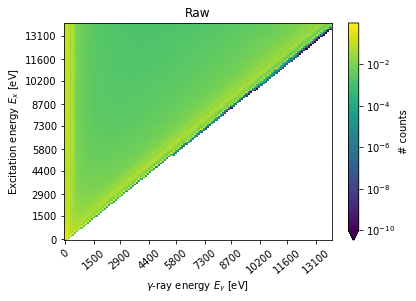

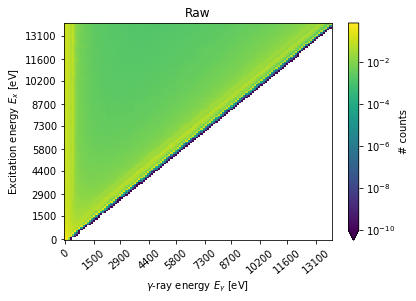

(<matplotlib.collections.QuadMesh at 0x7fd037f137b8>,
 <Figure size 432x288 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fd037fd1978>)

In [2]:
# Load a response matrix
fname_resp_mat = "unfolding/Si28_response_fwhm2.25perc.m"
R_mama_view = om.Matrix(path=fname_resp_mat)

fname_resp_mat = "unfolding/Si28_response_fwhm0.225perc.m"
R_mama_unf = om.Matrix(path=fname_resp_mat)

zmin_resp = 1e-10 # Plotting

# print("Calibration coefficients:", R_mama.calibration())
# print("E_max = ", R_mama.Eg.max())

R_mama_view.plot(scale="log", vmin=zmin_resp)
R_mama_unf.plot(scale="log", vmin=zmin_resp)
# plt.colorbar(cbar)

In [3]:
# Then do the same using OMpy functionality:
folderpath = "../../oscar2017_scale1.15"

# Energy calibration of resulting response matrix:
Eout_array = R_mama_view.Eg
assert(all(R_mama_view.Eg == R_mama_unf.Eg)), "Somethings wrong about the loaded matrixes"

fwhm_abs = 30 # (30/1330 = 2.25% )
# Experimental relative FWHM at 1.33 MeV of resulting array (TODO set up default value for this):
R_ompy_view, R_tab_view = om.interpolate_response(folderpath, Eout_array, fwhm_abs=fwhm_abs, return_table=True)
R_ompy_unf, R_tab_unf = om.interpolate_response(folderpath, Eout_array, fwhm_abs=fwhm_abs/10, return_table=True)

Note: The response below 200 keV is interpolation only, as there are no simulations available.
Note: The response below 200 keV is interpolation only, as there are no simulations available.


In [4]:
raw = om.example_raw("Si28")

# Response from MAMA
# FWHM: view
# Without compton subtraction
unfolder = om.Unfolder(response=R_mama_view)
unfolder.use_compton_subtraction = False
unfolded_mama_view = unfolder(raw)

# With compton subtraction
unfolder= om.Unfolder(response=R_mama_view)
unfolder.use_compton_subtraction = True
unfolder.response_tab = R_tab_view
unfolded_mama_view_cmp = unfolder(raw)

# FWHM: unf
# Without compton subtraction
unfolder = om.Unfolder(response=R_mama_unf)
unfolder.use_compton_subtraction = False
unfolded_mama_unf = unfolder(raw)

# With compton subtraction
unfolder= om.Unfolder(response=R_mama_unf)
unfolder.use_compton_subtraction = True
unfolder.response_tab = R_tab_unf
unfolded_mama_unf_cmp = unfolder(raw)

In [5]:
# Response from ompy
# FWHM: view
# Without compton subtraction
unfolder = om.Unfolder(response=R_ompy_view)
unfolder.use_compton_subtraction = False
unfolded_ompy_view = unfolder(raw)

# With compton subtraction
unfolder= om.Unfolder(response=R_ompy_view)
unfolder.use_compton_subtraction = True
unfolder.response_tab = R_tab_view
unfolded_ompy_ompy_cmp = unfolder(raw)

# FWHM: unf
# Without compton subtraction
unfolder = om.Unfolder(response=R_ompy_unf)
unfolder.use_compton_subtraction = False
unfolded_ompy_unf = unfolder(raw)

# With compton subtraction
unfolder= om.Unfolder(response=R_ompy_unf)
unfolder.use_compton_subtraction = True
unfolder.response_tab = R_tab_unf
unfolded_ompy_unf_cmp = unfolder(raw)

# With compton subtraction and all tweaks
unfolder= om.Unfolder(response=R_ompy_unf)
unfolder.use_compton_subtraction = True
unfolder.response_tab = R_tab_unf
unfolder.FWHM_tweak_multiplier = {"fe": 1., "se": 1.1,
                                     "de": 1.3, "511": 0.9}
unfolded_ompy_unf_cmp_tweaks = unfolder(raw)


In [6]:
fname = "unfolding/Si28_unf_fwhm0.255_withNeg.m"
unfolded_with_mama_unf = om.Matrix(path=fname)

# Did not remove negative counts in mama, as it works slightly different
unfolded_with_mama_unf.fill_negative(window_size=10)
unfolded_with_mama_unf.remove_negative()

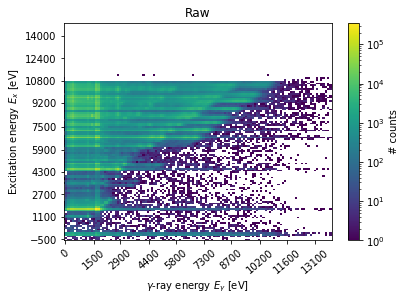

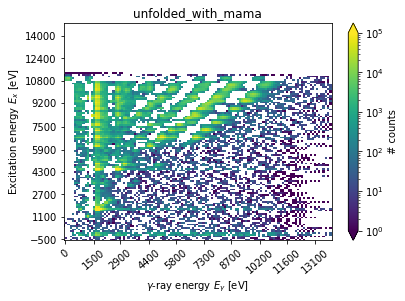

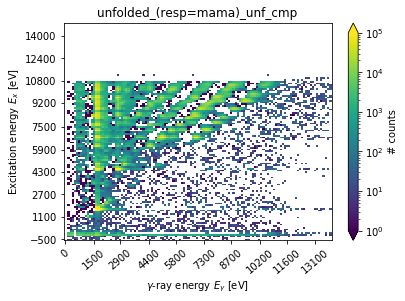

(<matplotlib.collections.QuadMesh at 0x7fd0376003c8>,
 <Figure size 432x288 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fd0375ef390>)

In [7]:
# %matplotlib notebook

vmin = 1
vmax = 1e5

raw.plot()
unfolded_with_mama_unf.plot(vmin=vmin, vmax=vmax, title="unfolded_with_mama")
unfolded_mama_unf_cmp.plot(vmin=vmin, vmax=vmax, title="unfolded_(resp=mama)_unf_cmp")

In [8]:
def plt_compare(E_arr, mat1, label1, mat2, label2, suptitle="projection of on Eg axis"):
    if len(E_arr)!=9:
        raise NotImplementedError("Have to work")
    fig, ax_mat = plt.subplots(3,3, constrained_layout=True,
                          sharex=False, sharey=False,
                          figsize=(10,6)
                          )
    for i, E in enumerate(E_arr):
        ax = ax_mat.flatten()[i]

        binwidth = mat1.Ex[1] - mat1.Ex[0]
        E_limits = [E-binwidth/2, E+binwidth/2]
        mat1.plot_projection(axis="Eg", Emin=E_limits[0],
                               Emax=E_limits[1], ax=ax, label=label1, linestyle="-.")

        binwidth = mat2.Ex[1] - mat2.Ex[0]
        E_limits = [E-binwidth/2, E+binwidth/2]
        mat2.plot_projection(axis="Eg", Emin=E_limits[0],
                               Emax=E_limits[1], ax=ax, label=label2, alpha=0.7, linestyle="--")

    #     ax.set_yscale("log")
    #     ax.set_ylim(1e-2,0.5)
        ax.set_xlim(0, E_arr[-1]+200)
        if i==1:
            ax.legend(fontsize=8, loc="best")

        if i<6:
            ax.set_xticklabels([])
        if i%3 != 0:
            ax.set_yticklabels([])
        
        ax.set_ylabel("")

        ax.text(0.5, .5, "{:.0f}+-{:.0f} keV".format(mat2.Ex[mat2.index_Ex(E)], binwidth/2),
               transform = ax.transAxes, fontsize=8)
    fig.suptitle(suptitle, fontsize=16)
    plt.subplots_adjust(wspace=0, hspace=0)
    return fig, ax_mat

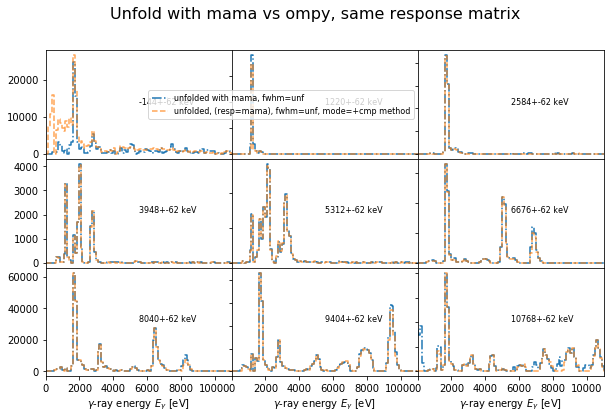

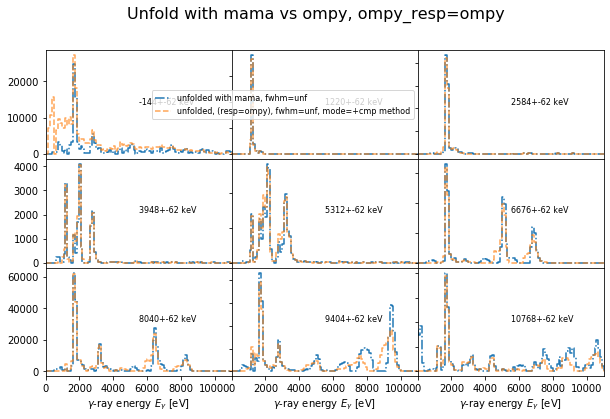

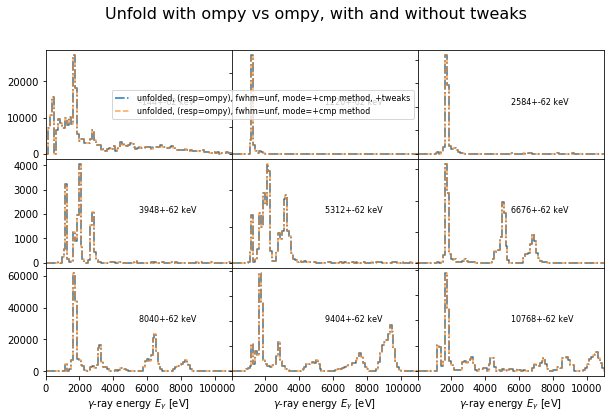

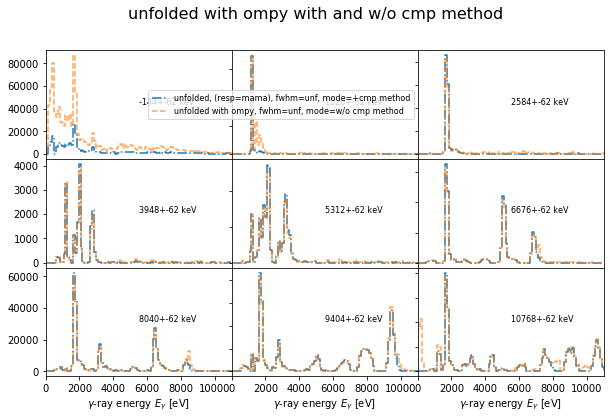

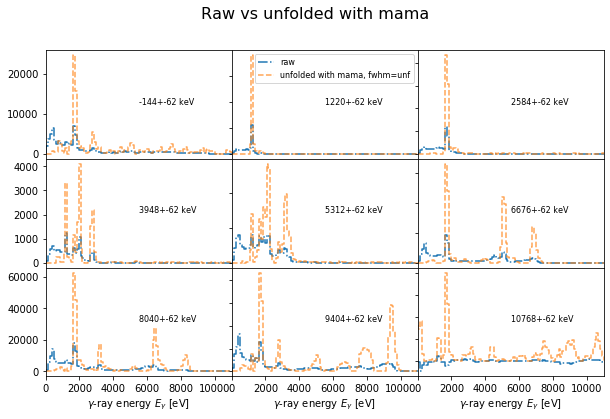

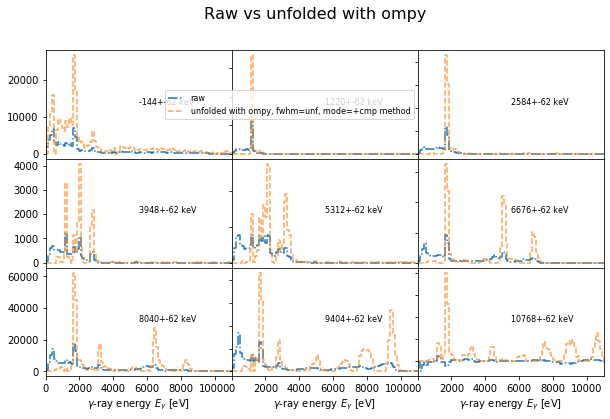

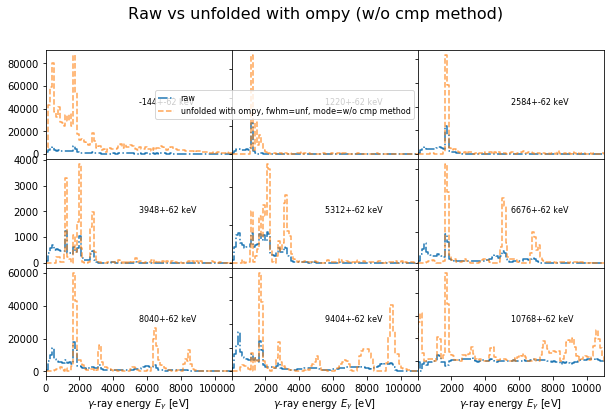

In [9]:
E_arr = np.linspace(-140, 10800, num=9)
# %matplotlib notebook
fig, ax_mat = plt_compare(E_arr, 
                        unfolded_with_mama_unf, "unfolded with mama, fwhm=unf", 
                        unfolded_mama_unf_cmp, "unfolded, (resp=mama), fwhm=unf, mode=+cmp method",
                        suptitle="Unfold with mama vs ompy, same response matrix" )
fig.savefig("unfolding/mama_vs_ompy_same_response_matrix.png")

fig, ax_mat = plt_compare(E_arr, 
                        unfolded_with_mama_unf, "unfolded with mama, fwhm=unf", 
                        unfolded_ompy_unf_cmp, "unfolded, (resp=ompy), fwhm=unf, mode=+cmp method",
                        suptitle="Unfold with mama vs ompy, ompy_resp=ompy" )
fig.savefig("unfolding/mama_vs_ompy_ompyResp=ompy_matrix.png")

fig, ax_mat = plt_compare(E_arr, 
                        unfolded_ompy_unf_cmp_tweaks, "unfolded, (resp=ompy), fwhm=unf, mode=+cmp method, +tweaks", 
                        unfolded_ompy_unf_cmp, "unfolded, (resp=ompy), fwhm=unf, mode=+cmp method",
                        suptitle="Unfold with ompy vs ompy, with and without tweaks" )
fig.savefig("unfolding/ompy_ompyResp=ompy_withAndWithoutTweaks.png")

fig, ax_mat = plt_compare(E_arr, 
                        unfolded_mama_unf_cmp, "unfolded, (resp=mama), fwhm=unf, mode=+cmp method",
                        unfolded_mama_unf, "unfolded with ompy, fwhm=unf, mode=w/o cmp method",
                        suptitle="unfolded with ompy with and w/o cmp method" )

fig, ax_mat = plt_compare(E_arr, 
                        raw, "raw", 
                        unfolded_with_mama_unf, "unfolded with mama, fwhm=unf",
                        suptitle="Raw vs unfolded with mama" )
fig.savefig("unfolding/raw_vs_unfolded_mama.png")

fig, ax_mat = plt_compare(E_arr, 
                        raw, "raw", 
                        unfolded_mama_unf_cmp, "unfolded with ompy, fwhm=unf, mode=+cmp method",
                        suptitle="Raw vs unfolded with ompy" )

fig, ax_mat = plt_compare(E_arr, 
                        raw, "raw", 
                        unfolded_mama_unf, "unfolded with ompy, fwhm=unf, mode=w/o cmp method",
                        suptitle="Raw vs unfolded with ompy (w/o cmp method)" )
fig.savefig("unfolding/raw_vs_unfolded_ompy.png")

plt.show()